# CAPTCHA Recognition

In [1]:
import os
import numpy as np
from matplotlib import pyplot
from matplotlib import image
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms

from PIL import Image

In [2]:
filenames = os.listdir('./archive')
labels_text = list(map(lambda x: x.split('.')[0], filenames))
to_tensor = transforms.ToTensor()
images = [
    to_tensor(
        Image.open(f"./archive/{x}")
    ) for x in filenames
]

In [3]:
import string

alphanumeric = {}

i = 0
while i < 10:
    onehot = [0] * 62
    onehot[i] = 1
    alphanumeric[str(i)] = onehot
    i += 1

for c in string.ascii_lowercase:
    onehot = [0] * 62
    onehot[i] = 1
    alphanumeric[c] = onehot
    i += 1

for c in string.ascii_uppercase:
    onehot = [0] * 62
    onehot[i] = 1
    alphanumeric[c] = onehot
    i += 1

labels = []
for l in labels_text:
    label = []
    for c in l:
        label += alphanumeric[c]
    labels.append(torch.tensor(label).float())

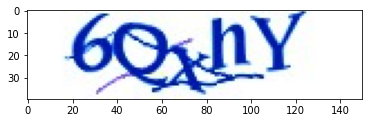

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [4]:
dataset = list(zip(images, labels))

index = 50
pyplot.imshow(dataset[index][0].permute(1, 2, 0))
pyplot.show()
dataset[index][1]

In [5]:
import random

random.shuffle(dataset)
div = int(len(dataset) * 0.8)

training_set = dataset[:div]
validation_set = dataset[div:]

In [11]:
class VGG11(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.conv7 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(2048, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 62 * 5)
    
    def forward(self, x):
        out = torch.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)

        out = torch.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)

        out = torch.relu(self.conv3(out))
        out = torch.relu(self.conv4(out))
        out = F.max_pool2d(out, 2)

        out = torch.relu(self.conv5(out))
        out = torch.relu(self.conv6(out))
        out = F.max_pool2d(out, 2)

        out = torch.relu(self.conv7(out))
        out = torch.relu(self.conv8(out))
        out = F.max_pool2d(out, 2)

        out = out.view(-1, 2048)

        out = torch.relu(self.fc1(out))
        out = torch.relu(self.fc2(out))
        out = torch.sigmoid(self.fc3(out))

        return out

class CNN_small(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(5760, 2048)
        self.fc2 = nn.Linear(2048, 62 * 5)
    
    def forward(self, x):
        out = torch.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)

        out = torch.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)

        out = torch.relu(self.conv3(out))
        out = F.max_pool2d(out, 2)

        out = out.view(-1, 5760)

        out = torch.relu(self.fc1(out))
        out = torch.sigmoid(self.fc2(out))

        return out

In [12]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()            
            optimizer.step()
            loss_train += loss.item()

        print('{} Epoch {}, Training loss {}'.format(
            datetime.datetime.now(), epoch,
            loss_train / len(train_loader)))

In [14]:
train_loader = torch.utils.data.DataLoader(training_set, batch_size=64, shuffle=True)

model = CNN_small()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader
)

2022-04-28 21:37:08.934934 Epoch 1, Training loss 28.66573613098015
2022-04-28 21:38:34.267473 Epoch 2, Training loss 28.611445051945925
2022-04-28 21:40:02.317536 Epoch 3, Training loss 28.58055779350529
2022-04-28 21:41:34.231170 Epoch 4, Training loss 28.575092369629942
2022-04-28 21:43:05.610654 Epoch 5, Training loss 28.562499368713464
2022-04-28 21:44:37.079629 Epoch 6, Training loss 28.49901436612832
2022-04-28 21:46:05.148137 Epoch 7, Training loss 28.395871527967223
2022-04-28 21:47:32.706292 Epoch 8, Training loss 28.294461967921492
2022-04-28 21:49:04.785166 Epoch 9, Training loss 28.216641656748813
2022-04-28 21:50:36.334774 Epoch 10, Training loss 28.154590044196965
2022-04-28 21:52:07.015928 Epoch 11, Training loss 28.09921197203295
2022-04-28 21:53:42.129411 Epoch 12, Training loss 28.05041110026617
2022-04-28 21:55:14.541580 Epoch 13, Training loss 27.999682439941665
2022-04-28 21:56:43.552654 Epoch 14, Training loss 27.94705851175829
2022-04-28 21:58:13.440452 Epoch 15

KeyboardInterrupt: 

In [ ]:
def extract_label_text(label_tensor):
    charset = "0123456789" + string.ascii_lowercase + string.ascii_uppercase

    chars_onehot = []
    for i in range(0, 310, 62):
        chars_onehot.append(list(label_tensor[i:i+62]))
    
    char_indices = [max(range(len(chars_onehot[i])), key=lambda x: chars_onehot[i][x]) for i in range(len(chars_onehot))]
    text = ''.join([charset[i] for i in char_indices])

    return text

In [ ]:
train_loader = torch.utils.data.DataLoader(training_set, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(validation_set, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # <1>
            for imgs, labels in loader:
                outputs = model(imgs)
                total += labels.shape[0]  # <3>

                for i in range(labels.shape[0]):
                    if extract_label_text(outputs[i]) == extract_label_text(labels[i]):
                        correct += 1

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.00
Accuracy val: 0.00
